# Scanpy: Scran Normalize

Use the Scran R package to normalize the data for later analysis.

### Setup and Load Data

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
import pandas as pd

import os
os.environ['R_HOME'] = r"C:\Program Files\R\R-4.4.1"   
import anndata2ri # order matters, comes after defining 'R_HOME'

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

# *** Input File ***  h5 file after filtering 
sample_name = r'granulomas'
h5_file_path = r'results/'
h5_file = h5_file_path + sample_name + '_final_raw.h5ad'

# *** Output Files ***  
results_file_path = r'results/'
lognorm_results_file = results_file_path + sample_name + r'_lognorm_scran.h5ad'  #  file to store the log normalized data

scanpy==1.10.1 anndata==0.8.0 umap==0.5.3 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.1.1 statsmodels==0.14.2 igraph==0.10.8 louvain==0.8.2 pynndescent==0.5.7


In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(6,6) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
# sc.logging.print_versions()

C:\Users\david\AppData\Local\Temp\ipykernel_59068\2438674924.py:7: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
D:\jupyter_3_10\jl\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
%%R
# Load R libraries
library(scran)

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: 'MatrixGenerics'

The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

In [4]:
adata = sc.read_h5ad(h5_file)
adata.X = adata.X.toarray() # convert to full matrix

print(adata.obs['sample'].value_counts())
print()
print('Data matrix is sparse:', sp.sparse.issparse(adata.X))
print()
print('X size =', adata.X.shape)

sample
granuloma2    9392
granuloma1    9302
granuloma3    8909
Name: count, dtype: int64

Data matrix is sparse: False

X size = (27603, 23693)


In [5]:
samples = set(adata.obs['sample'])
samples = sorted(samples, key=str.lower)
num_cells = []
num_genes = []
num_reads = []
for sample in samples:
    num_cells.append(adata[adata.obs['sample'] == sample].n_obs)
    num_genes.append(adata[adata.obs['sample'] == sample].n_vars)
    num_reads.append(adata[adata.obs['sample'] == sample].X.sum())
    
df = pd.DataFrame(list(zip(num_cells,num_genes,num_reads)), columns = ['Number of cells', 'Number of genes', 'Number of reads'], index = samples)
df 

,Number of cells,Number of genes,Number of reads
granuloma1,9302,23693,31901160.0
granuloma2,9392,23693,38253350.0
granuloma3,8909,23693,47596780.0


#### Principal Component Analysis

In [6]:
sc.tl.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:24)


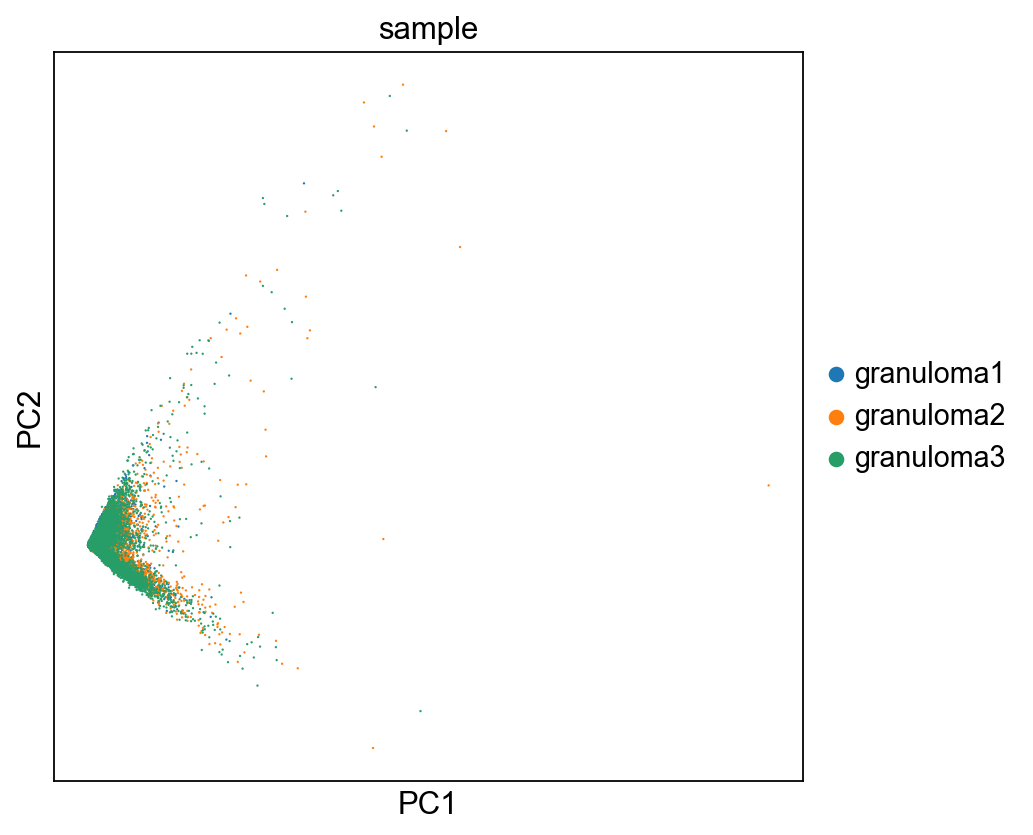

In [7]:
sc.pl.pca(adata, color="sample")

#### Examine initial distribution of total counts.

C:\Users\david\AppData\Local\Temp\ipykernel_59068\1022173236.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(adata.obs['n_counts'] , bins=50, kde=False)


<Axes: xlabel='n_counts'>

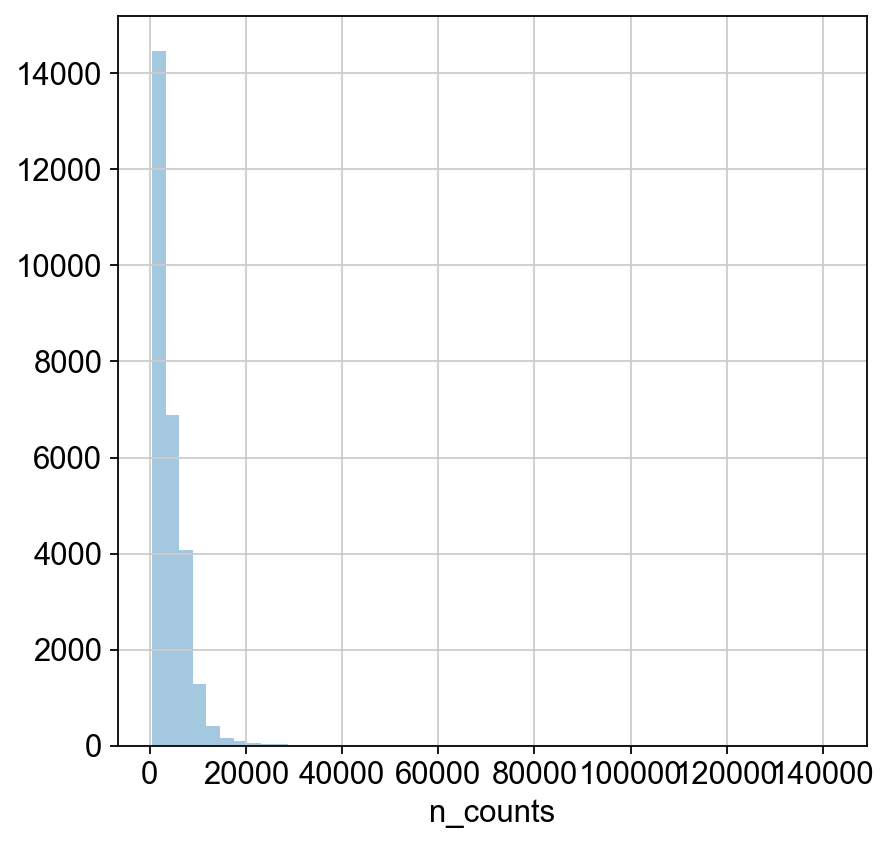

In [8]:
adata.obs['n_counts'] = adata.X.sum(1)
sb.distplot(adata.obs['n_counts'] , bins=50, kde=False)

### Scran Normalization
Scran calculates the cell normalization values.

In [9]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:58)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:23)


In [10]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

Slow step

In [11]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = sizeFactors(computeSumFactors(SingleCellExperiment(list(counts=data_mat)), clusters=input_groups, min.mean=0.1))

In [12]:
#Delete adata_pp
del adata_pp

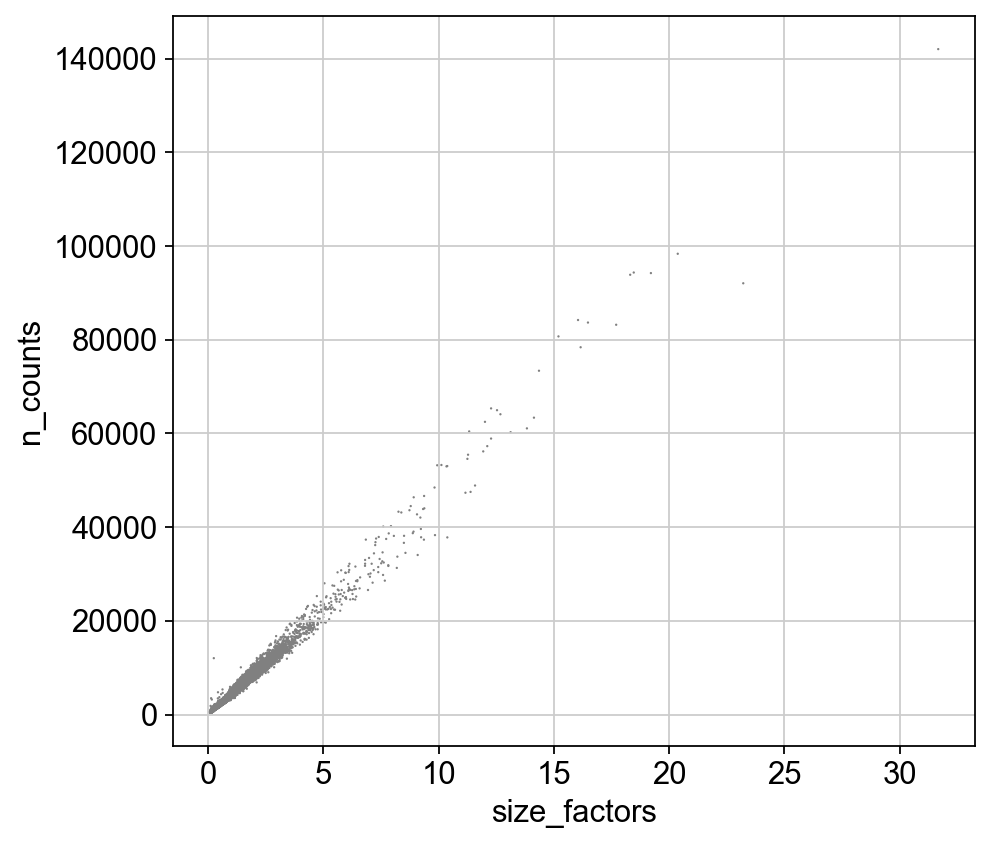

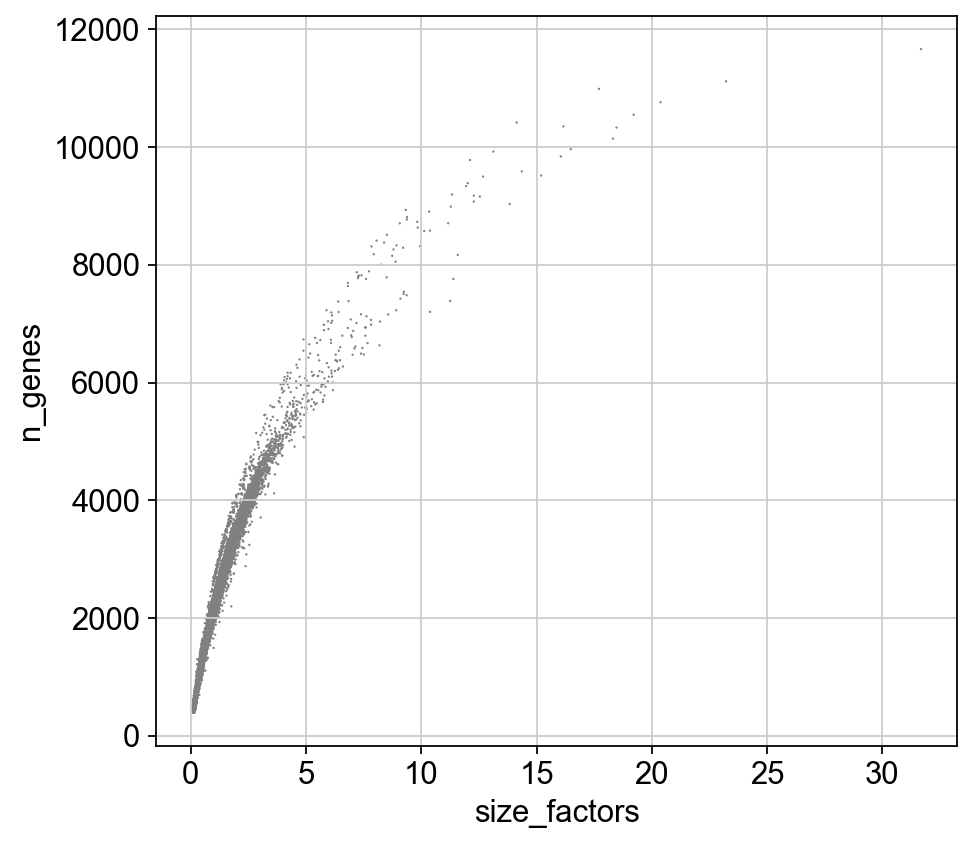

C:\Users\david\AppData\Local\Temp\ipykernel_59068\3101962420.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(size_factors, bins=50, kde=False)


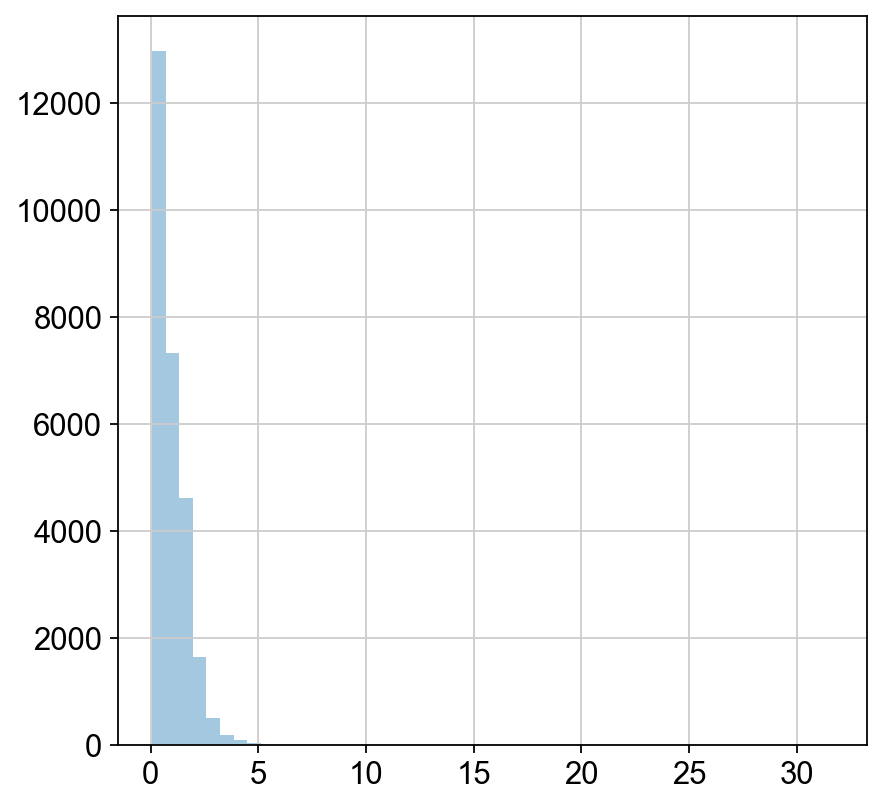

In [13]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors
adata.obs['n_counts'] =  adata.X.sum(1)

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [14]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [15]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]

AAACCTGAGCGTAGTG_sc69_1    4761.376953
AAACCTGAGCTGATAA_sc69_1    4226.493652
AAACCTGCAAATCCGT_sc69_1    3990.684570
AAACCTGCAAGGGTCA_sc69_1    4295.224609
AAACCTGCACATCCGG_sc69_1    4091.893066
                              ...     
TTTGTCAGTTCAACCA_sc72_1    4020.084961
TTTGTCAGTTCAGTAC_sc72_1    3493.775879
TTTGTCATCACAAACC_sc72_1    4119.310547
TTTGTCATCAGCACAT_sc72_1    3953.411133
TTTGTCATCTCGAGTA_sc72_1    4681.914062
Name: n_counts, Length: 27603, dtype: float32


C:\Users\david\AppData\Local\Temp\ipykernel_59068\2131238558.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(adata.obs['n_counts'] , bins=50, kde=False)


<Axes: xlabel='n_counts'>

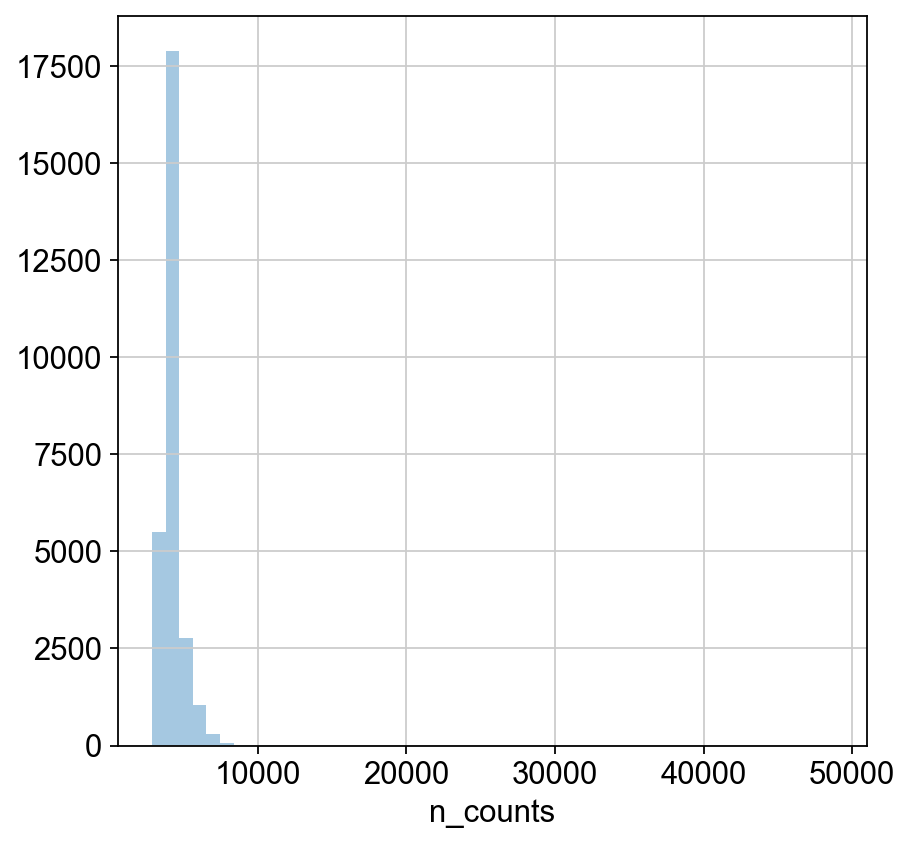

In [16]:
adata.obs['n_counts'] = adata.X.sum(1)
print(adata.obs['n_counts'])
sb.distplot(adata.obs['n_counts'] , bins=50, kde=False)

#### Principal Component Analysis

In [17]:
sc.tl.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:25)


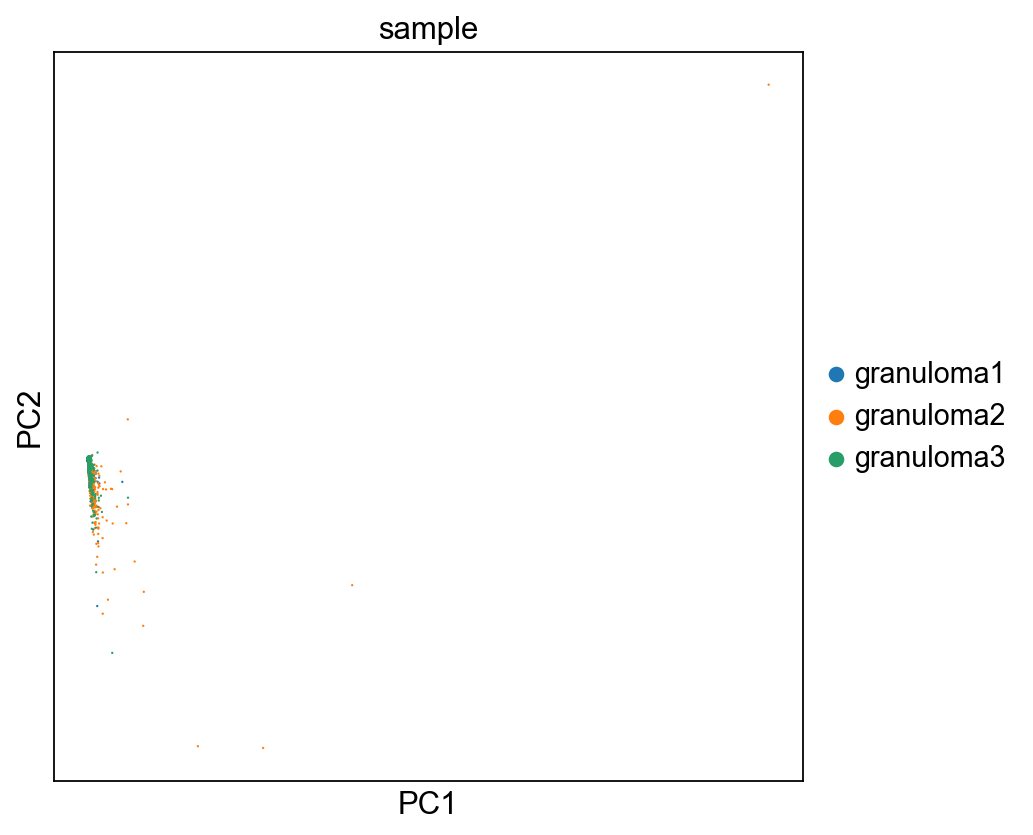

In [18]:
sc.pl.pca(adata, color="sample")

### Log Transform

In [19]:
sc.pp.log1p(adata)

AAACCTGAGCGTAGTG_sc69_1    2239.465332
AAACCTGAGCTGATAA_sc69_1    1611.851929
AAACCTGCAAATCCGT_sc69_1    2357.519775
AAACCTGCAAGGGTCA_sc69_1    1996.658447
AAACCTGCACATCCGG_sc69_1    2524.003418
                              ...     
TTTGTCAGTTCAACCA_sc72_1    2255.587646
TTTGTCAGTTCAGTAC_sc72_1    1666.929810
TTTGTCATCACAAACC_sc72_1    2344.677734
TTTGTCATCAGCACAT_sc72_1    2277.132812
TTTGTCATCTCGAGTA_sc72_1    2231.499023
Name: n_counts, Length: 27603, dtype: float32


C:\Users\david\AppData\Local\Temp\ipykernel_59068\2131238558.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(adata.obs['n_counts'] , bins=50, kde=False)


<Axes: xlabel='n_counts'>

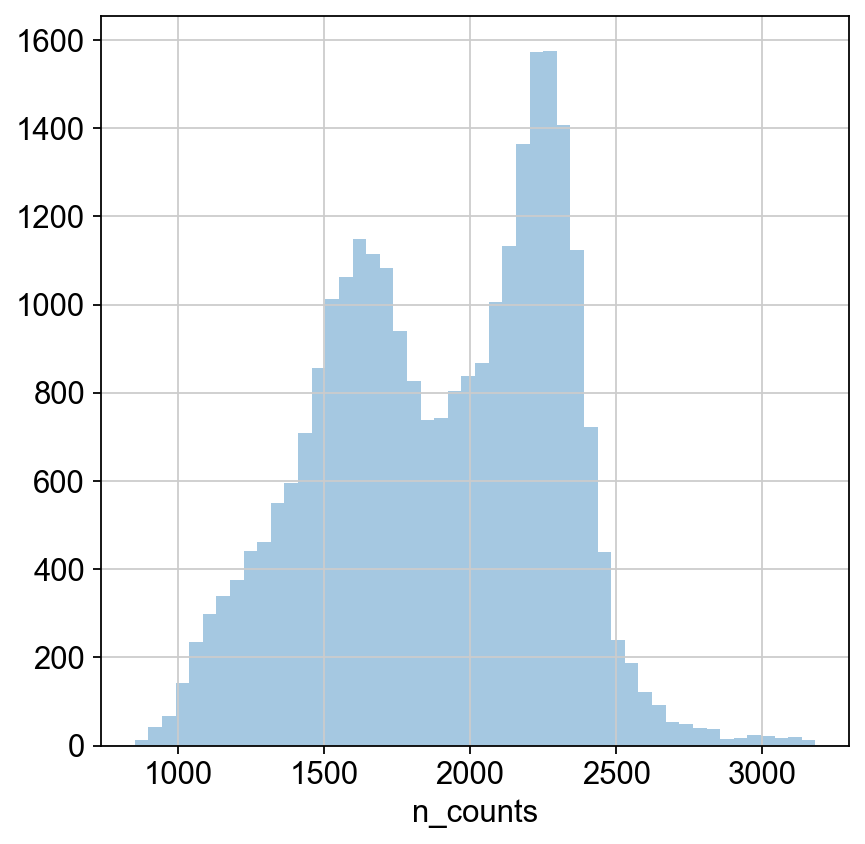

In [20]:
adata.obs['n_counts'] = adata.X.sum(1)
print(adata.obs['n_counts'])
sb.distplot(adata.obs['n_counts'] , bins=50, kde=False)

#### Principal Component Analysis
Differences in sequencing depth may reemerge after log transform

In [21]:
sc.tl.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:23)


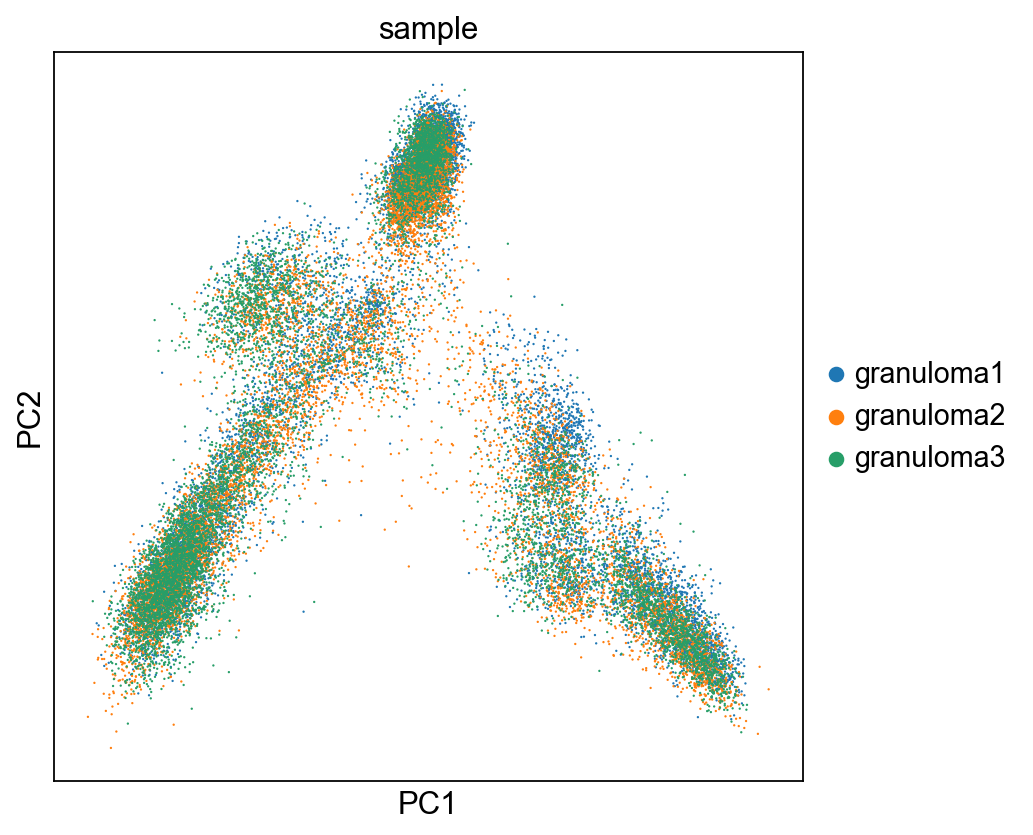

In [22]:
sc.pl.pca(adata, color="sample")

### Save Data

In [23]:
# save
adata.write_h5ad(lognorm_results_file)